In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import pytz
import tzlocal as tz

import cufflinks as cf
import numpy as np
import chart_studio.plotly as py
import seaborn as sns
import plotly.express as px
%matplotlib inline
import keyring
import requests

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

from datetime import datetime
from pytz import timezone
from tzlocal import get_localzone

### Read data and transform datatypes to datetime and adding additional time columns

In [2]:
# read in data, expand df to show all columns
# df_main = pd.read_csv('snow3300.csv')
df_main = pd.read_csv('snow5000.csv')

pd.set_option('max_columns', None)

nyc = timezone('America/New_York') 
df_main['resolved_at'] = pd.to_datetime(df_main['resolved_at']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['work_start'] = pd.to_datetime(df_main['work_start']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['calendar_duration'] = pd.to_datetime(df_main['calendar_duration']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['reopened_time'] = pd.to_datetime(df_main['reopened_time']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['opened_at'] = pd.to_datetime(df_main['opened_at']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['closed_at'] = pd.to_datetime(df_main['closed_at']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['sys_updated_on'] = pd.to_datetime(df_main['sys_updated_on']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['sys_created_on'] = pd.to_datetime(df_main['sys_created_on']).dt.tz_localize('UTC').dt.tz_convert(nyc)
df_main['business_duration'] = pd.to_datetime(df_main['business_duration']).dt.tz_localize('UTC').dt.tz_convert(nyc)


df_main['opened_at_hour'] = df_main['opened_at'].dt.hour
df_main['opened_at_month'] = df_main['opened_at'].dt.month
df_main['opened_at_day'] = df_main['opened_at'].dt.day
df_main['opened_at_day_of_year'] = df_main['opened_at'].dt.dayofyear
df_main['opened_at_clone'] = df_main['opened_at']
df_main['resolution_hour'] = df_main['resolved_at'].dt.hour
df_main['resolution_time_length'] = df_main.resolved_at - df_main.opened_at
df_main['resolution_time_total_hours'] = df_main['resolution_time_length'].dt.total_seconds()/3600
# print(type(df_main['opened_at_clone'].iloc[0]))
df_main[['opened_at', 'task_effective_number', 'opened_at_hour', 'opened_at_month', 'opened_at_day', 'opened_at_day_of_year',
         'opened_at_clone', 'resolution_time_length',
         'resolution_time_total_hours']].head(5).sort_values('opened_at_day').head(2)

# place all transformations here
df_main = df_main.replace(['2d5d343adb2d17009f9aec51ca9619e9'],['five9'])
df_main = df_main.replace(['55da5d83db3057007f3dec51ca96190c'],['Unknown_CI'])

# TO INCLUDE ONLY RESULTS AFTER OCTOBER, USE THIS
df_main = df_main[ df_main['opened_at'] > '2020-10-01' ]

In [3]:
df_main[ df_main['resolved_at'].isnull() ].head(2)

,u_repeat,made_sla,upon_reject,u_money_movement,sys_updated_on,child_incidents,task_effective_number,number,u_vcc,sys_updated_by,sys_created_on,u_dollar_impact,state,sys_created_by,knowledge,u_external_customer_impacted,u_ach,calendar_stc,closed_at,impact,active,priority,sys_domain_path,opened_at,business_duration,reopened_time,resolved_at,u_hub,u_avidpay_check,u_core,u_ipay,subcategory,u_avidpay_direct,short_description,work_start,close_code,u_pir_requested,u_check,business_stc,calendar_duration,notify,sys_class_name,close_notes,parent_incident,u_choice_6,sys_id,contact_type,reopened_by,incident_state,urgency,u_utility,reassignment_count,severity,approval,sys_mod_count,reopen_count,u_board,escalation,upon_approval,u_payments_delayed,category,resolved_by_username_value,opened_by_value,sys_domain_value,configuration_item_value,caller_id_value,assignment_group_value,closed_by_value,parent_incident_value,assigned_to_value,location_value,business_service_value,opened_at_hour,opened_at_month,opened_at_day,opened_at_day_of_year,opened_at_clone,resolution_hour,resolution_time_length,resolution_time_total_hours
20,False,True,cancel,False,2021-06-02 08:26:19-04:00,0,INC0074858,INC0074858,False,X110405,2021-06-02 08:06:04-04:00,0,2,kmcdonough,False,False,False,NaN,NaT,3,True,4,/,2021-06-02 08:06:04-04:00,NaT,NaT,NaT,False,False,False,False,NaN,False,TPM could not be initialized,NaT,NaN,False,False,NaN,NaT,1,incident,NaN,NaN,1.0,020f6174db60309020acde82ca961993,Self Service,NaN,2,2,False,0,3,not requested,1,0,False,0,proceed,False,NaN,NaN,e1cb2daddb582600a7895e09af9619d9,global,e6553e78db83e74020acde82ca9619d7,e1cb2daddb582600a7895e09af9619d9,fe169ea0db5e2700bd3ec170ba961941,NaN,NaN,Shawn McCoy,5d43995edbe69b0020acde82ca961994,fe169ea0db5e2700bd3ec170ba961941,8,6,2,153,2021-06-02 08:06:04-04:00,NaN,NaT,NaN
760,False,True,cancel,False,2021-06-01 08:36:20-04:00,0,INC0073776,INC0073776,False,X110405,2021-05-25 14:28:44-04:00,0,2,akansal,False,False,False,NaN,NaT,3,True,4,/,2021-05-25 14:28:44-04:00,NaT,NaT,NaT,False,False,False,False,Laptop,False,Surface Laptop Not Performing,NaT,NaN,False,False,NaN,NaT,1,incident,NaN,NaN,1.0,5969f996db1cfc105cfba895ca961931,Self Service,NaN,2,2,False,0,3,not requested,3,0,False,0,proceed,False,hardware,NaN,dccb2daddb582600a7895e09af961937,global,e6553e78db83e74020acde82ca9619d7,dccb2daddb582600a7895e09af961937,fe169ea0db5e2700bd3ec170ba961941,NaN,NaN,Shawn McCoy,5d43995edbe69b0020acde82ca961994,fe169ea0db5e2700bd3ec170ba961941,14,5,25,145,2021-05-25 14:28:44-04:00,NaN,NaT,NaN


### How many INC are opened per hour (assigned to included within our search parameters)

In [4]:
df_inc_per_hr = df_main['task_effective_number'].groupby(df_main['opened_at'].dt.hour).count()
# df_inc_per_hr

fig = px.bar(df_inc_per_hr, x=df_inc_per_hr.index, y='task_effective_number',
             labels={'opened_at':'Hour Opened', 'task_effective_number':'Total Count of Incidents'})
fig.show()

# fig.write_image("fig1.png")

### How many INC are resolved per hour (assigned to included within our search parameters)

In [5]:
df_resolve_dist = df_main['task_effective_number'].groupby(df_main['resolved_at'].dt.hour).count()
# df_inc_per_hr

fig = px.bar(df_resolve_dist, x=df_resolve_dist.index, y='task_effective_number',
             labels={'resolved_at':'Hour Resolved', 'task_effective_number':'Total Count of Incidents'})
fig.show()

# which INC are closed late-night
# df_main[df_main['resolution_hour'] == 23]

### What is the timeframe of this data

In [6]:
# to pull days as int (for calculations)
# print((df_main['opened_at'].max() - df_main['opened_at'].min()).days)
print('Total number of incidents tracked within this selection: ' + str(df_main['opened_at'].count()))
print('earliest incident:        '+str(df_main['opened_at'].dt.date.min()))
print('latest incident:          '+str(df_main['opened_at'].dt.date.max()))
print('timespan/range of earliest to latest:   '+str(df_main['opened_at'].max() - df_main['opened_at'].min()))

Total number of incidents tracked within this selection: 3924
earliest incident:        2020-10-01
latest incident:          2021-06-02
timespan/range of earliest to latest:   244 days 11:11:36


### How quickly are INC resolved

In [7]:
# Histogram of INC resolved per hour
df_resolution_time = df_main['resolution_time_length']
fig = px.histogram(df_main['resolution_time_total_hours'], x="resolution_time_total_hours", range_x=[0,200])

fig.update_traces(xbins=dict( # bins/intervals used for histogram
        size=1
    ))

fig.show()

In [8]:
# Histogram of INC resolved per hour
df_resolution_time = df_main['resolution_time_length']
fig = px.histogram(df_main['resolution_time_total_hours'], x="resolution_time_total_hours", histnorm='percent')

fig.update_traces(xbins=dict( # bins/intervals used for histogram
        start=0.0,
        end=30.0,
        size=0.5
    ))

fig.show()

In [9]:
# place series values into bins for histogram
# only works on NUMERICAL columns
df_main['resolution_time_length'].value_counts(normalize=True, ascending=False, bins=1350).head(5)

(-1 days +22:39:22.513999999, 0 days 00:59:43.322962962]    0.325688
(0 days 00:59:43.322962962, 0 days 01:59:26.645925925]      0.137360
(0 days 01:59:26.645925925, 0 days 02:59:09.968888888]      0.068807
(0 days 02:59:09.968888888, 0 days 03:58:53.291851851]      0.046381
(0 days 03:58:53.291851851, 0 days 04:58:36.614814814]      0.031600
Name: resolution_time_length, dtype: float64

In [10]:
# breakdown of resolution time column
df_main['resolution_time_length'].describe()

count                         3909
mean     1 days 01:59:04.103607060
std      2 days 16:17:37.794404772
min                0 days 00:00:00
25%                0 days 00:39:22
50%                0 days 02:26:33
75%                0 days 22:12:35
max               55 days 23:44:46
Name: resolution_time_length, dtype: object

### Boxplot of resolution time (showing outlier INC)

In [11]:
# df_main.boxplot(column='resolution_time_total_hours')
fig = px.box(df_main, y="resolution_time_total_hours")
fig.show()

In [12]:
# breakdown of resolution time column WITHOUT OUTLIER
df_main['resolution_time_length'][ df_main['resolution_time_length'] < '1200 hours' ].describe()

count                         3908
mean     1 days 01:38:50.198311156
std      2 days 12:44:48.770845657
min                0 days 00:00:00
25%                0 days 00:39:22
50%                0 days 02:26:31
75%         0 days 22:12:25.250000
max               33 days 12:13:19
Name: resolution_time_length, dtype: object

### Who has opened the most tickets overall?

In [13]:
# show number of tickets by INC-caller 
fig = px.bar(df_main['sys_created_by'].value_counts(), x=df_main['sys_created_by'].value_counts().index,
             y='sys_created_by', labels={'x':'Username', 'sys_created_by':'Number of INC opened'})
fig.update_xaxes(range=[0,50])
fig.show()

### Who has opened the most tickets overall? (as a percentage)

In [14]:
# show percentage of tickets by INC-caller
percent = df_main['sys_created_by'].value_counts(normalize=True, ascending=False)

fig = px.bar(percent, x=percent.index,
             y='sys_created_by', labels={'index':'Username', 'sys_created_by':'Percent of total INC opened'})
fig.update_xaxes(range=[0,50])
fig.show()

### Who has opened the most tickets lately? (rolling week/month)

In [15]:
# show number of tickets by INC-caller 
fig = px.bar(df_main['sys_created_by'][ df_main['opened_at'] > '2021-03-01' ].value_counts(),
             x=df_main['sys_created_by'][ df_main['opened_at'] > '2021-03-01' ].value_counts().index,
             y='sys_created_by', labels={'x':'Username', 'sys_created_by':'Number of INC opened'})
fig.update_xaxes(range=[0,50])
fig.show()

### Which type of incidents take the longest amount of time? (more than 5 days)

In [16]:
# how many INC took more than 5 days
df_lots_of_time = df_main[ df_main['resolution_time_length'] > '5 days 00:00:00' ]
print('Number of INC open more than 5 days:',df_lots_of_time['resolution_time_length'].count())

# What is percent of tickets that took longer than 5 days
print('Percent of tickets open longer than 5 days:', df_lots_of_time['resolution_time_length'].count()
      /df_main['opened_at'].count())

# df_lots_of_time['category'][df_lots_of_time['category']!=0].value_counts()
fig = px.bar(df_lots_of_time['category'][df_lots_of_time['category']!=0].value_counts(),
             x=df_lots_of_time['category'][df_lots_of_time['category']!=0].value_counts().index,
             y='category')
fig.show()

Number of INC open more than 5 days: 224
Percent of tickets open longer than 5 days: 0.05708460754332314


### By Subcategory

In [17]:
fig = px.bar(df_lots_of_time['subcategory'][df_lots_of_time['subcategory']!=0].value_counts(),
             x=df_lots_of_time['subcategory'][df_lots_of_time['subcategory']!=0].value_counts().index,
             y='subcategory')
fig.show()

### Distribution of INC type (as percentage)

In [18]:
# df_lots_of_time['subcategory'].value_counts().head()
fig = px.bar(df_main['subcategory'][df_main['subcategory']!=0].value_counts(normalize=True, ascending=False),
             x=df_main['subcategory'][df_main['subcategory']!=0].value_counts().index,
             y='subcategory')
fig.show()

### What INC types are quickest to resolve? (under 1 hr)

In [19]:
# how many INC took less than 30min
df_quick_resolve = df_main[ df_main['resolution_time_length'] < '0 days 00:30:00' ]
print('Number of INC resolved within 30 minutes:',df_quick_resolve['resolution_time_length'].count())

# What is percent of tickets that took less than 30min to resolve
print('Percent of tickets resolved within 30 minutes:', df_quick_resolve['resolution_time_length'].count()
      /df_main['opened_at'].count())

# df_lots_of_time['category'][df_lots_of_time['category']!=0].value_counts()
fig = px.bar(df_quick_resolve['category'][df_quick_resolve['category']!=0].value_counts(),
             x=df_quick_resolve['category'][df_quick_resolve['category']!=0].value_counts().index,
             y='category')
fig.show()

Number of INC resolved within 30 minutes: 817
Percent of tickets resolved within 30 minutes: 0.2082059123343527


In [20]:
# fig = px.bar(df_quick_resolve['subcategory'][df_quick_resolve['subcategory']!=0].value_counts(),
#              x=df_quick_resolve['subcategory'][df_quick_resolve['subcategory']!=0].value_counts().index,
#              y='subcategory')
# fig.show()

In [21]:
# replace 'NaN' values with '0'
# not sure if this actually should be done. I think it did not reflect null values until changing to a 0
df_main['subcategory'] = df_main['subcategory'].fillna(0)
df_main['category'] = df_main['category'].fillna(0)

### Where are we leaving "subcategory" unfilled?

In [22]:
# what are incidents where subcategory is null?
df_no_subcategory = df_main[ df_main['subcategory'] == 0 ]
# df_no_subcategory[['task_effective_number', 'resolved_by_username_value', 'short_description', 'subcategory']].head()
fig = px.bar(df_no_subcategory['category'][df_no_subcategory['category']!=0].value_counts(),
             x=df_no_subcategory['category'][df_no_subcategory['category']!=0].value_counts().index,
             y='category')
fig.show()

In [23]:
# How many INC are there with subcategory set to 'null'
print('Number of INC with subcategory "Null":',df_main['task_effective_number'][ df_main['subcategory'] == 0 ].count())
# as percent of all INC
print('Percent of INC with subcategory "Null"', (df_main['task_effective_number'][ df_main['subcategory'] == 0 ].count())
      / df_main['task_effective_number'].count())

Number of INC with subcategory "Null": 997
Percent of INC with subcategory "Null" 0.25407747196738023


### Wordcloud of short description field for MFA requests

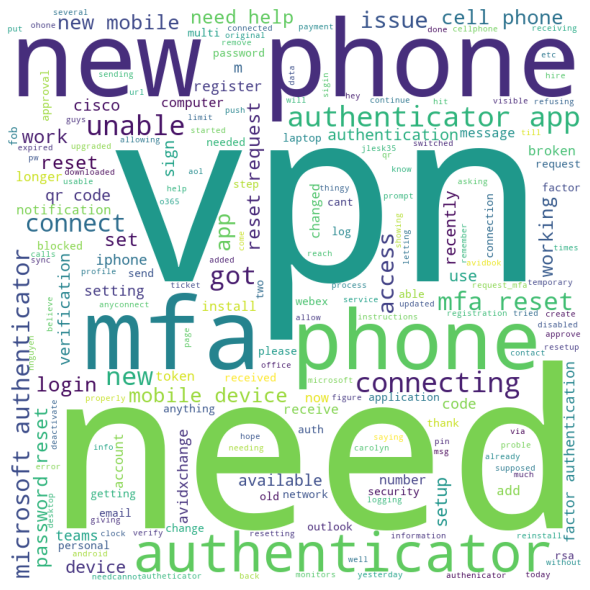

In [24]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/

# build word cloud for meta tag spotting
df_mfa = df_main[ df_main['subcategory'] == 'Multi-Factor / RSA Authentication' ]
df_mfa['task_effective_number'].count()

comment_words = 'need'
stopwords = set(STOPWORDS)
  
# iterate through the df
for val in df_mfa.short_description:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [25]:
# how many five9 tickets
df_five9 = df_main[ df_main['configuration_item_value'] == 'five9' ]
print('Total count of five9 tickets: ', df_five9['task_effective_number'].count())
# what is avg resolution time for five9 tickets
print('Average five9 ticket resolution time: ', df_five9['resolution_time_length'].mean())

Total count of five9 tickets:  825
Average five9 ticket resolution time:  1 days 00:56:34.397810218


### Ticket resolution percentage by username

In [26]:
# who is resolving tickets (for all time)
df_main['resolved_by_username_value'].value_counts(normalize=True).head()

Taylor Ramsey                       0.472244
Shawn McCoy                         0.259146
Valentin Correa                     0.189307
Tiffany Leonard                     0.015349
f1a999a4db0168d09f9aec51ca9619a4    0.006907
Name: resolved_by_username_value, dtype: float64

In [27]:
# who is resolving tickets (as total percentage within the last week)
df_main['resolved_by_username_value'][ df_main['opened_at'] > '2021-03-01' ].value_counts(normalize=True).head()

Taylor Ramsey                       0.441031
Valentin Correa                     0.273725
Shawn McCoy                         0.207899
f1a999a4db0168d09f9aec51ca9619a4    0.014811
Tiffany Leonard                     0.007680
Name: resolved_by_username_value, dtype: float64

### Ticket resolution numbers (Overall)

In [28]:
df_main['opened_at'].groupby(df_main['resolved_by_username_value']).count().sort_values(ascending=False)

resolved_by_username_value
Taylor Ramsey                       1846
Shawn McCoy                         1013
Valentin Correa                      740
Tiffany Leonard                       60
f1a999a4db0168d09f9aec51ca9619a4      27
                                    ... 
555678b6dba190905cfba895ca96193e       1
52cb6daddb582600a7895e09af96194e       1
5158836adbe744d020acde82ca961940       1
4acb6daddb582600a7895e09af96192d       1
fe05baaadb3673009f9aec51ca9619d3       1
Name: opened_at, Length: 117, dtype: int64

In [29]:
# # THIS IS A BAD WAY TO DO THIS, earliest time here is: 2018-12-18 15:47:12
# df_five9_by_day = df_five9['task_effective_number'].groupby(df_main['opened_at_day_of_year']).count()
# fig = px.line(df_five9_by_day, x=df_five9_by_day.index, y="task_effective_number", title='Count of Five9 INC Per Day')
# fig.show()

### Count of five9 INC per day

In [30]:
# Count of five9 INC per day (since january)
# resetting index to the opened_at_clone field 
try:
    df_five9.set_index('opened_at_clone', inplace=True)
except:
    pass

# RESAMPLING 'B' FOR BUSINESS DAYS (getting rid of weekends in the graph)
df_five9_resample_b = df_five9['task_effective_number'].resample('B').count()

fig = px.line(df_five9_resample_b, x=df_five9_resample_b.index, y=df_five9['task_effective_number'].resample('B').count(), title='Count of Five9 INC Per Day')
fig.show()

### Count of five9 INC per day (Since Jan 1st 2021)

In [31]:
# Count of five9 INC per day (since january)
df_new = df_five9[df_five9.index > '2021-01-01']
df_five9_resample_b = df_new['task_effective_number'].resample('B').count()
fig = px.line(df_five9_resample_b, x=df_five9_resample_b.index, y=df_new['task_effective_number'].resample('B').count(), title='Count of Five9 INC Per Day')
fig.show()

In [32]:
try:
    df_main.set_index('opened_at_clone', inplace=True)
except:
    pass

print('Number of days covered:',len(df_five9_resample_b.index))
df_main_resample_b = df_main['task_effective_number'].resample('B').count()
print('Number of days covered:',len(df_main_resample_b.index))

print(len(df_new['task_effective_number'].resample('B').count()))
print(len(df_main['task_effective_number'].resample('B').count()))

Number of days covered: 109
Number of days covered: 175
109
175


### Total count of INC opened per day

In [33]:
fig = px.line(df_five9_resample_b, x=df_main_resample_b.index, y=df_main['task_effective_number'].resample('B').count(), title='Count of Total INC Per Day')
fig.show()

### How many INC have broken SLA

In [34]:
# How many have broken SLA?
print('Count of INC that did not meet SLA:', df_main['made_sla'][df_main['made_sla'] == False].count())

Count of INC that did not meet SLA: 0


### How many ticekts are re-opened, and in what categories

In [35]:
# how many INC took less than 1hr
# df_quick_resolve = df_main['reopen_count'][df_main['reopen_count'] !=0].count()
print('Number of INC reopened:',df_main['reopen_count'][df_main['reopen_count'] !=0].count())

# What is percent of tickets that took less than 1hr to resolve
print('Percent of tickets reopened:',
     df_main['reopen_count'][df_main['reopen_count'] !=0].count() / df_main['opened_at'].count())

# make new df
df_reopen = df_main[df_main['reopen_count'] !=0]

# df_lots_of_time['category'][df_lots_of_time['category']!=0].value_counts()
fig = px.bar(df_reopen['category'][df_reopen['category']!=0].value_counts(),
             x=df_reopen['category'][df_reopen['category']!=0].value_counts().index,
             y='category')
fig.show()

Number of INC reopened: 71
Percent of tickets reopened: 0.018093781855249746


### Count of Five9 vs. Total Daily INC Count

In [36]:
# FIVE9 AND TOTAL INC OVERLAY
df_new = df_main[df_main.index > '2021-01-01']
df_five9_resample_b = df_new['task_effective_number'].resample('B').count()
fig = px.line(df_five9_resample_b,
              x=df_five9_resample_b.index,
              y=df_new['task_effective_number'].resample('B').count(),
              title='Count of Total INC, Five9 INC Per Day',)
fig.add_scatter(x=df_five9_resample_b.index, y=df_new['task_effective_number'].resample('B').count(), name='Total INC')
# fig.update_trace(line_color='#005D6B')
fig.add_scatter(x=df_five9_resample_b.index, y=df_five9['task_effective_number'].resample('B').count(), name='Five9')
# fig.update_traces(line_color='#00A04E')
fig.show()

In [37]:
# df_main['resolution_time_length'].mean().groupby(df_main['resolved_at'].dt.date)
print('Total number of INC with Unknown CI:', df_main['task_effective_number'][df_main['configuration_item_value'] == 'Unknown_CI' ].count())
print('Percent of total INC:', df_main['task_effective_number'][df_main['configuration_item_value'] == 'Unknown_CI' ].count()/df_main['task_effective_number'].count())

Total number of INC with Unknown CI: 1604
Percent of total INC: 0.4087665647298675


In [38]:
fig = px.bar(df_main['sys_created_by'][ df_main['opened_at'] > '2021-03-01' ].value_counts(),
             x=df_main['sys_created_by'][ df_main['opened_at'] > '2021-03-01' ].value_counts().index,
             y='sys_created_by', labels={'x':'Username', 'sys_created_by':'Number of INC opened'},
            title="Who is opening the most INC?")
fig.update_xaxes(range=[0,50])
fig.show()

### Heatmap showing ticket resolution by agent over time

In [39]:
# build new column
df_main['resolved_at_date'] = df_main['resolved_at'].dt.date

# df1
df_tay_day = df_main[ df_main['resolved_by_username_value'] == 'Taylor Ramsey' ]
df_tay_day.groupby('resolved_at_date').resolved_by_username_value.count()
df_tay_day = df_tay_day.groupby('resolved_at_date').resolved_by_username_value.count()
dftay = df_tay_day.to_frame().reset_index()
dftay['Name'] = 'Taylor'
# dftay.count()

# df2
df_shawn_day = df_main[ df_main['resolved_by_username_value'] == 'Shawn McCoy' ]
df_shawn_day.groupby('resolved_at_date').resolved_by_username_value.count()
df_shawn_day = df_shawn_day.groupby('resolved_at_date').resolved_by_username_value.count()
dfshawn = df_shawn_day.to_frame().reset_index()
dfshawn['Name'] = 'Shawn'
# dfshawn.count()

# df3
df_valentin_day = df_main[ df_main['resolved_by_username_value'] == 'Valentin Correa' ]
df_valentin_day.groupby('resolved_at_date').resolved_by_username_value.count()
df_valentin_day = df_valentin_day.groupby('resolved_at_date').resolved_by_username_value.count()
dfvalentin = df_valentin_day.to_frame().reset_index()
dfvalentin['Name'] = 'Valentin'
# dfvalentin.count()

df_test = dftay.append(dfshawn).sort_values('resolved_at_date')
df_test2 = df_test.append(dfvalentin).sort_values('resolved_at_date')


fig = px.density_heatmap(df_test2, x='resolved_at_date', y='Name', z='resolved_by_username_value',
                         color_continuous_scale='Viridis')

fig.update_layout(
    title='Monthly Resolved Incidents',
    xaxis_nticks=20)

fig

### Heatmap showing INC count by category over time

In [40]:
# shorten the timespan
# df_main = df_main[ df_main['resolved_at'] > '2021-01-01' ]

df_main['opened_at_date'] = df_main['opened_at'].dt.date

# df1
df_five9 = df_main[ df_main['subcategory'] == 'Soft Phone' ]
# df_five9.groupby('opened_at_date').sys_created_by.count()
df_five9 = df_five9.groupby('opened_at_date').sys_created_by.count()
dff9 = df_five9.to_frame().reset_index()
dff9['Name'] = 'Five9'
# dff9.count()

# df2
df_Laptop = df_main[ df_main['subcategory'] == 'Laptop' ]
# df_Laptop.groupby('opened_at_date').sys_created_by.count()
df_Laptop = df_Laptop.groupby('opened_at_date').sys_created_by.count()
dflaptop = df_Laptop.to_frame().reset_index()
dflaptop['Name'] = 'Laptop'
# dflaptop.count()

# df3
df_Desktop = df_main[ df_main['subcategory'] == 'Desktop' ]
# df_Desktop.groupby('opened_at_date').sys_created_by.count()
df_Desktop = df_Desktop.groupby('opened_at_date').sys_created_by.count()
dfdesktop = df_Desktop.to_frame().reset_index()
dfdesktop['Name'] = 'Desktop'
# dfdesktop.count()

# df4
df_MFA = df_main[ df_main['subcategory'] == 'Multi-Factor / RSA Authentication' ]
# df_Desktop.groupby('opened_at_date').sys_created_by.count()
df_MFA = df_MFA.groupby('opened_at_date').sys_created_by.count()
dfmfa = df_MFA.to_frame().reset_index()
dfmfa['Name'] = 'MFA'
# dfdesktop.count()

df_test = dff9.append(dflaptop).sort_values('opened_at_date')
df_test2 = df_test.append(dfdesktop).sort_values('opened_at_date')
df_test3 = df_test2.append(dfmfa).sort_values('opened_at_date')


fig = px.density_heatmap(df_test3, x='opened_at_date', y='Name', z='sys_created_by')

fig.update_layout(
    title='Monthly Resolved Incidents',
    xaxis_nticks=20)

fig

### Whose tickets take longest to resolve?

In [41]:
df_main.groupby('sys_created_by').resolution_time_total_hours.mean().sort_values(ascending=False).head(10)

sys_created_by
KDemaria     402.241111
X104991      385.717778
JSuess       356.171389
RFoster      335.966944
X110301      335.219167
RSprince     290.335000
NMack        288.514722
Kthompson    288.357778
SHart        264.505556
ctinsley     243.410556
Name: resolution_time_total_hours, dtype: float64